## Deep Learning for Hydrologic Forecasting: LSTM and Transformer Modeling with the CAMELS Dataset (Jiangtao Liu)

## 📘 1. Overview

In this tutorial, we will explore how to use the **CAMELS (Catchment Attributes and Meteorology for Large-sample Studies)** dataset to build deep learning models for rainfall–runoff prediction.
You will learn how to preprocess hydrologic data, construct and train **LSTM** and **Transformer** models, and evaluate their predictive performance.

To make the tutorial lightweight and runnable on Colab (even without GPU),
we’ll use a **small subset (20 basins)** of CAMELS that has been pre-processed and stored as a NetCDF file.

> 💡 *The full CAMELS dataset can be downloaded and processed using the provided [Python scripts](https://zenodo.org/records/17087240)
> (`01.download_camels.py`, `02.prepare_camels.py`), which takes about 20 minutes.*

---

### 📜 References

> Liu, J., Bian, Y., Lawson, K., & Shen, C. (2024). [*Probing the limit of hydrologic predictability with the Transformer network.*](https://doi.org/10.1016/j.jhydrol.2024.131389) Journal of Hydrology, 637, 131389.

> Liu, J., Shen, C., O'Donncha, F., Song, Y., et al. (2025). [*From RNNs to Transformers: Benchmarking deep learning architectures for hydrologic prediction.*](https://doi.org/10.5194/egusphere-2025-1706) EGUsphere, 2025.


### Acknowledgment:

I would like to thank ChatGPT and Claude for their assistance in organizing and refining this tutorial notebook.

---


## **2. Environment Setup**

You can run this notebook directly in **Google Colab**.
Most dependencies are already available.
#### 💻 How to enable GPU in Colab

1. Click on the menu bar: **`Runtime` → `Change runtime type`**
2. Under **Hardware accelerator**, choose **`T4 GPU`**
3. Click **Save**, and the notebook will restart automatically.
4. Then run the cell below to verify that PyTorch detects the GPU.

⚠️ If you exceed Colab’s free usage limits, you’ll need to subscribe to Colab Pro / Pro+ or use other GPU resources (e.g., Kaggle, RunPod, Lambda Labs, etc.).

In [ ]:
# Check GPU availability
import torch, platform
print("Torch version:", torch.__version__)
print("Python version:", platform.python_version())
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Torch version: 2.8.0+cu126
Python version: 3.12.12
CUDA available: True
Device name: Tesla T4


In [ ]:
!pip install cartopy
# Optional: install or update packages if needed
# !pip install torch einops xarray netCDF4 matplotlib tqdm numpy pandas scipy

# Optional: mount Google Drive to save outputs
# from google.colab import drive
# drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 100.2 MB/s eta 0:00:00



## 3. What Is the CAMELS Dataset?

The Catchment Attributes and Meteorology for Large-sample Studies (**CAMELS**) dataset provides hydrometeorological observations for 671 catchments across the continental United States.
It includes:

* **Meteorological forcing data:** precipitation, temperature, radiation, etc. (from *Daymet*, *NLDAS*, *Maurer*)
* **Static basin attributes:** topography, soil, vegetation, and climate characteristics.
* **Observed discharge (runoff)** data.

For this tutorial, we use a **subset of basins** and pre-computed variables to demonstrate the workflow quickly.

![Example](https://raw.githubusercontent.com/dl4water/dl4water-workshop-2025/main/2025-10-18_Building_LSTM_and_Transformer_Models_for_Hydrologic_Prediction/figures/Dapeng_Paper_CAMELS_variables.JPG)

(table credit: https://doi.org/10.1029/2019WR026793)

**Reference:**
A. Newman; K. Sampson; M. P. Clark; A. Bock; R. J. Viger; D. Blodgett, 2014. A large-sample watershed-scale hydrometeorological dataset for the contiguous USA. Boulder, CO: UCAR/NCAR. https://dx.doi.org/10.5065/D6MW2F4D

---

## **4. Load the Preprocessed CAMELS Subset**

We’ll use a preprocessed file (20 basins) to skip the heavy data preparation stage.
Download it directly from your GitHub repository.

This file contains:

* `forcing`:  (basin, time, feature)
* `target`:   (basin, time, 1)
* `static_data`: (basin, static_feature)

In [ ]:
# Create working directories
import os
os.makedirs("data", exist_ok=True)
os.makedirs("figures", exist_ok=True)

!wget -O /content/data/nc_reader.py "https://raw.githubusercontent.com/dl4water/dl4water-workshop-2025/main/2025-10-18_Building_LSTM_and_Transformer_Models_for_Hydrologic_Prediction/nc_reader.py"
!wget -O /content/data/CAMELS_subset.nc "https://raw.githubusercontent.com/dl4water/dl4water-workshop-2025/main/2025-10-18_Building_LSTM_and_Transformer_Models_for_Hydrologic_Prediction/CAMELS_subset.nc"
!touch /content/data/__init__.py

--2025-10-18 14:13:35--  https://raw.githubusercontent.com/dl4water/dl4water-workshop-2025/main/2025-10-18_Building_LSTM_and_Transformer_Models_for_Hydrologic_Prediction/nc_reader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7222 (7.1K) [text/plain]
Saving to: ‘/content/data/nc_reader.py’

/content/data/nc_re 100%[===================>]   7.05K  --.-KB/s    in 0s      

2025-10-18 14:13:35 (101 MB/s) - ‘/content/data/nc_reader.py’ saved [7222/7222]

--2025-10-18 14:13:35--  https://raw.githubusercontent.com/dl4water/dl4water-workshop-2025/main/2025-10-18_Building_LSTM_and_Transformer_Models_for_Hydrologic_Prediction/CAMELS_subset.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...


### **4.1 Inspect Dataset Structure**
This dataset contains:

* **Dynamic forcings** such as precipitation, temperature, radiation, PET
  (from *Daymet*, *NLDAS*, *Maurer*)
* **Static attributes** such as elevation, slope, soil depth, vegetation cover
* **Observed discharge and runoff**

In [ ]:
import xarray as xr
ds = xr.open_dataset("data/CAMELS_subset.nc")
ds

<xarray.Dataset> Size: 58MB
Dimensions:               (station_ids: 20, time: 12784)
Coordinates:
  * station_ids           (station_ids) <U8 640B '06464500' ... '02300700'
  * time                  (time) datetime64[ns] 102kB 1980-01-01 ... 2014-12-31
    lat                   (station_ids) float64 160B ...
    lon                   (station_ids) float64 160B ...
Data variables: (12/64)
    daymet_prcp           (station_ids, time) float64 2MB ...
    daymet_srad           (station_ids, time) float64 2MB ...
    daymet_tmax           (station_ids, time) float64 2MB ...
    daymet_tmin           (station_ids, time) float64 2MB ...
    daymet_vp             (station_ids, time) float64 2MB ...
    daymet_dayl           (station_ids, time) float64 2MB ...
    ...                    ...
    glim_1st_class_frac   (station_ids) float64 160B ...
    geol_2nd_class        (station_ids) <U31 2kB ...
    glim_2nd_class_frac   (station_ids) float64 160B ...
    carbonate_rocks_frac  (station_ids) float64 160B ...
    geol_porostiy         (station_ids) float64 160B ...
    geol_permeability     (station_ids) float64 160B ...
Attributes:
    title:            CAMELS Dataset for RainFlow with PET
    source:           https://ral.ucar.edu/solutions/products/camels
    processing_date:  2025-09-27T20:35:41.487752
    date_range:       1980-01-01 to 2014-12-31
    pet_method:       Hargreaves
    variable_naming:  Unified naming: {dataset}_{variable} for forcing, stati...

### **4.2 List Available Forcing Variables**

Let’s display which variables belong to each data source.


In [ ]:
forcing_vars = [v for v in ds.data_vars if any(src in v for src in ["daymet", "nldas", "maurer"])]
static_vars  = [v for v in ds.data_vars if v not in forcing_vars + ["QObs", "Runoff"]]
print("Total forcing variables:", len(forcing_vars))
print("Total static attributes:", len(static_vars))
print("\nSample forcing variables:", forcing_vars[:8])


Total forcing variables: 27
Total static attributes: 35

Sample forcing variables: ['daymet_prcp', 'daymet_srad', 'daymet_tmax', 'daymet_tmin', 'daymet_vp', 'daymet_dayl', 'daymet_swe', 'daymet_pet']


### **4.3 Visualize Basin Locations**

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


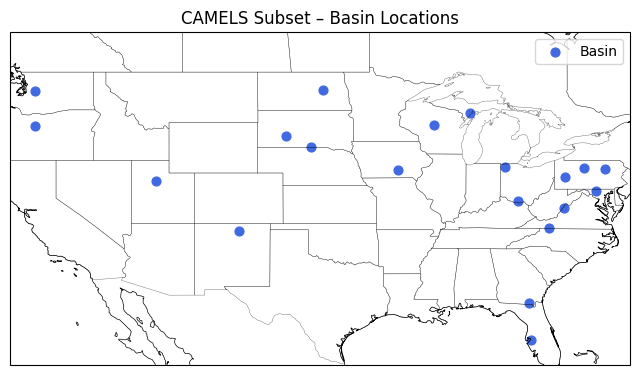

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Get basin coordinates
lons = ds["lon"].values
lats = ds["lat"].values
stations = ds["station_ids"].values

# Define map extent with small margins
lon_min, lon_max = lons.min() - 2, lons.max() + 2
lat_min, lat_max = lats.min() - 2, lats.max() + 2

# Create map
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add geographic context
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.3, alpha=0.6)

# Scatter basins
sc = ax.scatter(lons, lats, s=40, c="royalblue", transform=ccrs.PlateCarree(), label="Basin")

# Set map bounds and gridlines
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# Title and legend
plt.title("CAMELS Subset – Basin Locations", fontsize=12)
plt.legend()
plt.show()


### **4.4 Plot a Sample Time Series**

Choose one basin and plot precipitation, and observed runoff. We can observe that there is usually a time lag of several days between precipitation and runoff.

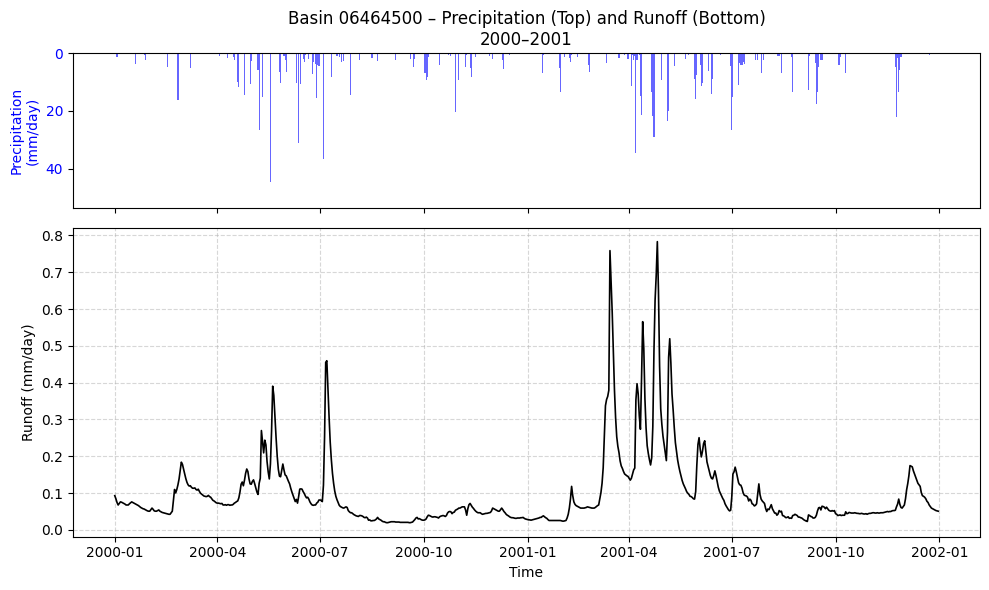

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select basin and time window
basin_id = str(ds["station_ids"].values[0])
start_date = "2000-01-01"
end_date   = "2001-12-31"

# Extract variables
precip = ds["daymet_prcp"].sel(station_ids=basin_id, time=slice(start_date, end_date))
runoff = ds["Runoff"].sel(station_ids=basin_id, time=slice(start_date, end_date))
time   = precip["time"].values

# --- Create figure with two stacked axes ---
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10,6), sharex=True,
    gridspec_kw={"height_ratios": [1, 2]}  # top (rain) smaller than bottom (runoff)
)

# ----- Top: Precipitation -----
ax1.bar(time, precip, width=1.0, color="blue", alpha=0.6)
ax1.set_ylabel("Precipitation\n(mm/day)", color="blue")
ax1.set_ylim(precip.max()*1.2, 0)  # invert axis: rainfall from top downward
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f"Basin {basin_id} – Precipitation (Top) and Runoff (Bottom)\n{start_date[:4]}–{end_date[:4]}")

# ----- Bottom: Runoff -----
ax2.plot(time, runoff, color="black", linewidth=1.2)
ax2.set_ylabel("Runoff (mm/day)", color="black")
ax2.tick_params(axis='y', labelcolor='black')
ax2.grid(True, linestyle="--", alpha=0.5)
ax2.set_xlabel("Time")

plt.tight_layout()
plt.show()


### **4.5 Static Attributes Overview**

Explore static variables such as elevation, slope, forest fraction, etc.

In [ ]:
import pandas as pd

static_df = ds[["elev_mean","slope_mean","area_gages2","frac_forest","soil_depth_pelletier"]].to_dataframe()
display(static_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
elev_mean,20.0,697.973500,659.451938,25.46000,279.125000,525.825000,795.992500,2791.360000
slope_mean,20.0,39.524854,51.119662,1.56449,5.729685,12.917685,48.883120,165.098190
area_gages2,20.0,987.647000,1094.989122,57.48000,161.537500,612.745000,1094.092500,3322.150000
frac_forest,20.0,0.568230,0.418231,0.00000,0.108875,0.725150,0.980925,0.995600
soil_depth_pelletier,20.0,17.962127,19.772785,0.63786,1.057601,5.832717,37.181211,49.355492
lat,20.0,40.610271,5.038353,27.79197,38.664110,41.288010,44.164257,47.558050
lon,20.0,-91.833258,14.430651,-121.64788,-100.277275,-85.815595,-80.676393,-76.534670


## **5 Why Normalize the Data?**

Different variables in our dataset — for example, precipitation, temperature, and PET — have very different ranges and units.
Precipitation might be in millimeters per day, temperature in degrees Celsius, and PET could have yet another scale.

If we feed these raw values directly into a neural network, the large numbers from one variable can dominate the smaller ones,
and the model may have trouble learning properly.

So, we use normalization to put all features on a similar scale, usually centered around zero.
This makes the training more stable and helps the model learn the relationships between variables more effectively.

We’ll apply **z-score normalization**:

$$x' = \frac{x - \mu}{\sigma}$$


where (\mu) and (\sigma) are the mean and standard deviation computed over the training period.

To make predictions in real units again, we use the inverse transform:

$$x = x' \cdot \sigma + \mu$$

After normalization, each variable has a mean close to zero and a similar range,
so the values become more balanced and easier for the model to learn from.

---

### **5.1 Compute Mean and Standard Deviation**

Here we compute statistics over all basins × time for each selected variable.

In [ ]:
import numpy as np
import xarray as xr

# Choose a few dynamic variables for demonstration
vars_to_normalize = ["daymet_prcp", "daymet_pet", "daymet_tmean"]

mean_dict = {}
std_dict  = {}

for v in vars_to_normalize:
    data = ds[v]
    mean_dict[v] = float(data.mean())
    std_dict[v]  = float(data.std())

print("Means:\n", mean_dict)
print("\nStandard deviations:\n", std_dict)

Means:
 {'daymet_prcp': 3.030225242490652, 'daymet_pet': 2.7968932732220417, 'daymet_tmean': 9.408116395494599}

Standard deviations:
 {'daymet_prcp': 7.037029544076663, 'daymet_pet': 1.8935152868461065, 'daymet_tmean': 10.818674410720746}


### **5.2 Apply Normalization**


In [ ]:
# Create a new normalized copy
ds_norm = ds.copy()

for v in vars_to_normalize:
    ds_norm[v] = (ds[v] - mean_dict[v]) / std_dict[v]

# Normalize static attributes as well (optional, usually per-feature)
static_vars = ["elev_mean", "slope_mean", "area_gages2", "frac_forest"]
for v in static_vars:
    mean_v = float(ds[v].mean())
    std_v  = float(ds[v].std())
    ds_norm[v] = (ds[v] - mean_v) / std_v

### **5.3 Visualize Normalization Effect**

We’ll compare one basin’s variable before and after normalization. This plot clearly shows that normalization changes the **scale** of the data, but not its **trend** — the overall seasonal pattern remains the same.

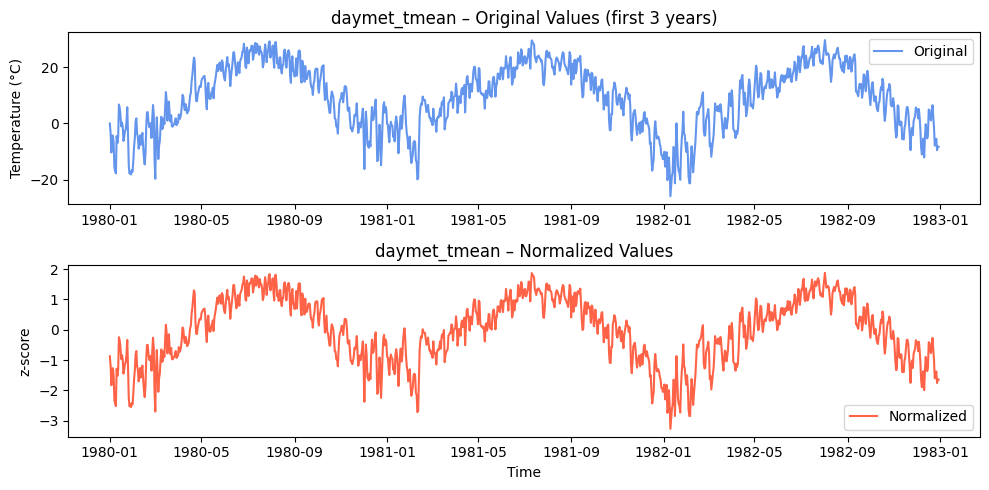

In [ ]:
import matplotlib.pyplot as plt

# Pick a basin and variable
basin_id = str(ds["station_ids"].values[0])
time = ds["time"].values

var = "daymet_tmean"   # average daily temperature
orig = ds[var].sel(station_ids=basin_id)
norm = ds_norm[var].sel(station_ids=basin_id)

plt.figure(figsize=(10,5))

# Original temperature values (first 3 years)
plt.subplot(2,1,1)
plt.plot(time[:365*3], orig[:365*3], label="Original", color="cornflowerblue")
plt.title(f"{var} – Original Values (first 3 years)")
plt.ylabel("Temperature (°C)")
plt.legend()

# Normalized values
plt.subplot(2,1,2)
plt.plot(time[:365*3], norm[:365*3], label="Normalized", color="tomato")
plt.title(f"{var} – Normalized Values")
plt.xlabel("Time")
plt.ylabel("z-score")
plt.legend()

plt.tight_layout()
plt.show()



### **5.4 Denormalization Example**

When evaluating predictions, we’ll want to convert model outputs back to physical units.
This step is essential because **metrics like RMSE or NSE must be computed in the same physical scale as the observations** (e.g., mm/day for runoff, °C for temperature).
Otherwise, the evaluation would not be physically meaningful.

$$x = x' \cdot \sigma + \mu$$


In [ ]:
import numpy as np

# Example: denormalize daymet_tmean (temperature)
recovered = ds_norm["daymet_tmean"] * std_dict["daymet_tmean"] + mean_dict["daymet_tmean"]

# Verify that we recover the original distribution
diff = float(np.abs(recovered - ds["daymet_tmean"]).mean())
print(f"Mean absolute difference after denormalization: {diff:.6e}")


Mean absolute difference after denormalization: 2.539733e-16


## **6 Recurrent Neural Networks (RNN)**

### **6.1 What is an RNN?**

A **Recurrent Neural Network (RNN)** processes sequences step by step —
each day’s prediction depends not only on today’s input (x_t),
but also on what the model remembers from the previous days.

At each time step (t):

$$
h_t = \tanh(W_x x_t + W_h h_{t-1} + b)
$$

* (x_t): current input (e.g., today’s precipitation, temperature)
* (h_{t-1}): previous hidden state (memory)
* (h_t): updated hidden state

This means the RNN **keeps a running memory** of the sequence as it moves through time.

---

### **6.2 Information Flow in Time**

Here’s how an RNN processes data across three time steps:

```
x1 ─▶ [RNN Cell] ─▶ h1 ─▶
            │
            ▼
x2 ─▶ [RNN Cell] ─▶ h2 ─▶
            │
            ▼
x3 ─▶ [RNN Cell] ─▶ h3 ─▶ ...
```

Each “RNN Cell” is the **same set of weights** used repeatedly —
the network reuses its previous hidden state (h_{t-1}) as memory when reading the next input (x_t).

> 💡 *Think of it like a hydrologic model carrying yesterday’s soil moisture into today’s runoff calculation.*

![Example](https://raw.githubusercontent.com/dl4water/dl4water-workshop-2025/main/2025-10-18_Building_LSTM_and_Transformer_Models_for_Hydrologic_Prediction/figures/RNN.png)


(credit: https://doi.org/10.1038/nature14539)


### **6.3 The Limitation: Forgetting the Distant Past**

However, when sequences get long, gradients flowing through many time steps become very small:

* The model **forgets older events** (e.g., rainfall 30 days ago)
* Training can become unstable — this is the **vanishing gradient problem**

In hydrology, this is critical because **runoff can depend on rainfall from days ago**.

---

### **6.4 Why We Need LSTM**

> To solve this, the **Long Short-Term Memory (LSTM)** network introduces a *cell state*
> and *gates* that decide what information to **keep**, **forget**, or **output**.
> This allows the model to remember longer-term dependencies stably.


![Example](https://raw.githubusercontent.com/dl4water/dl4water-workshop-2025/main/2025-10-18_Building_LSTM_and_Transformer_Models_for_Hydrologic_Prediction/figures/RNN_LSTM.png)

https://dl4water.github.io/tutorial-rnn-lstm

## **7 LSTM Basics and Architecture**

### **7.1 Why LSTM for Rainfall–Runoff Modeling?**

Rainfall–runoff processes have **memory**: today’s discharge depends on precipitation and states from previous days.
**LSTM** introduces a memory cell and gates to preserve and control long-term information, making it well-suited for hydrologic time series.

---

### **7.2 The LSTM Cell (with equations)**

At time step (t), given input (x_t) and previous hidden state (h_{t-1}), the LSTM computes:

![Example](https://raw.githubusercontent.com/dl4water/dl4water-workshop-2025/main/2025-10-18_Building_LSTM_and_Transformer_Models_for_Hydrologic_Prediction/figures/LSTM.png)


(credit: https://jmyao17.github.io/Machine_Learning/Sequence/RNN-1.html)

### **7.3 Understanding Input and Output Shapes**

In PyTorch, an LSTM expects input of shape:

$$
[\text{batch_size},\ \text{seq_len},\ \text{input_size}]
$$

and returns:

* `output`: tensor of shape ($$[\text{batch_size},\ \text{seq_len},\ \text{hidden_size}]$$)
* `(h_n, c_n)`: the final hidden and cell states for each layer, both shape ($$[\text{num_layers},\ \text{batch_size},\ \text{hidden_size}]$$)

Example for a hydrology model:

* `input_size = 6` → (precip, PET, temperature, radiation, vpd, swe)
* `seq_len = 30` days
* `batch_size = 64`
* `hidden_size = 128`

Then:

```text
Input:  [64, 30, 6]
Output: [64, 30, 128]
h_n:    [1, 64, 128]
c_n:    [1, 64, 128]
```

---

### **7.4 LSTM Example**

In [ ]:
import torch
import torch.nn as nn

# define sizes
batch_size = 2
seq_len = 5
input_size = 3
hidden_size = 4
num_layers = 1

# build model
lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

# dummy input: [batch, seq_len, input_size]
x = torch.randn(batch_size, seq_len, input_size)

# forward pass
output, (h_n, c_n) = lstm(x)

print("Input shape :", x.shape)
print("Output shape:", output.shape)
print("h_n shape   :", h_n.shape)
print("c_n shape   :", c_n.shape)

# view first sample’s time-series output
print("\nSample output (batch 0):")
print(output[0])

Input shape : torch.Size([2, 5, 3])
Output shape: torch.Size([2, 5, 4])
h_n shape   : torch.Size([1, 2, 4])
c_n shape   : torch.Size([1, 2, 4])

Sample output (batch 0):
tensor([[ 0.1623,  0.1835, -0.2232, -0.3274],
        [ 0.0951,  0.1660, -0.1750, -0.1109],
        [ 0.0283,  0.0920, -0.0649, -0.0066],
        [-0.0017,  0.4981, -0.0413,  0.0539],
        [-0.1495,  0.2801,  0.0858,  0.0407]], grad_fn=<SelectBackward0>)


This means for each time step, LSTM produces a 4-dimensional hidden representation.
You can feed this representation into a linear layer to predict runoff values.

## **8 Loss Functions and Visualization**

### **8.1 Why Loss Functions Matter**

The loss function tells the network **how far its predictions are from reality** and drives the gradient updates.
For hydrological regression tasks such as runoff prediction, we often use **Mean Squared Error (MSE)**:

$$
\text{MSE} = \frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y}_i)^2
$$

It penalizes large errors more strongly than small ones.
However, some basins have much larger discharge magnitudes, so we can use a **weighted MSE** to normalize by each basin’s variability.

---

### **8.2 Weighted MSE in Hydrology**

We often scale each basin’s loss by its target standard deviation (\sigma_y) so that all basins contribute equally:

$$
\text{Weighted MSE} =
\frac{1}{N} \sum_i
\left(
\frac{y_i - \hat{y}_i}{\sigma_{y,i}}
\right)^2
$$

**Where:**

- $y_i$: the true value (observed runoff)  
- $\hat{y}_i$: the model prediction  
- $\sigma_{y,i}$: the target standard deviation for basin *i* (computed from the training set)  
- $N$: the total number of samples

This reduces bias toward high-flow catchments.

---

### **8.3 Simple Python Example (with visualization)**

Below, we compare **MSE**, and **Weighted MSE** for three example basins.
The figure compares **unweighted** and **weighted** mean squared error for two basins:
one with **small flows** (around 1 mm/day) and one with **large flows** (around 20 mm/day).

* In the **blue bars (Unweighted MSE)**, the large-flow basin dominates the loss value because its discharge is much higher — even though both basins have roughly the same *relative error*.
  This means that if we trained a model using the plain MSE, most of the gradient updates would come from large basins, while small basins would have almost no influence.

* In the **orange bars (Weighted MSE)**, we divide each basin’s error by its own standard deviation before squaring.
  After this normalization, both basins contribute roughly the same amount to the total loss.
  This makes the training process **fairer and more balanced**, allowing the model to learn patterns that work across *all* basins instead of only the large ones.

In short:

> **Unweighted MSE → dominated by high-flow basins**
> **Weighted MSE → balanced learning across basins**



Plain MSE (overall): 1.71
Weighted MSE (overall): 0.30


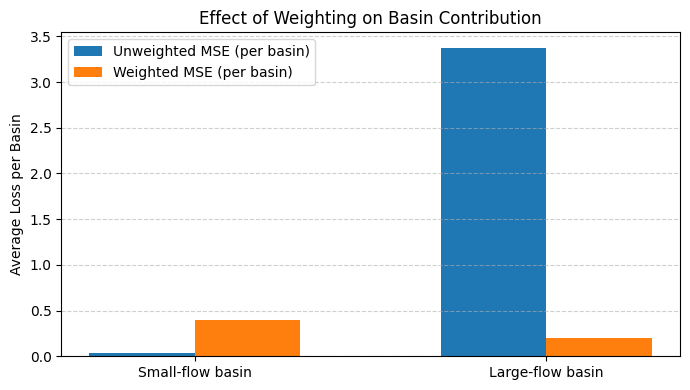

In [ ]:
import torch, matplotlib.pyplot as plt
torch.manual_seed(0)

# Two basins: small-flow and large-flow
y_true  = torch.tensor([[1.0, 1.5, 1.2, 0.8],        # small-flow basin
                        [10., 12., 11., 19.]])   # large-flow basin

# Model predictions with similar relative error (~10%), but different absolute error
y_pred  = y_true + torch.tensor([[0.2, -0.3, 0.1, 0.0],
                                 [2., -2.5, 1.5, -1.]])

# Compute per-basin loss contributions
plain_mse_per_basin = ((y_true - y_pred)**2).mean(dim=1)
y_std = y_true.std(dim=1, keepdim=True)
weighted_mse_per_basin = (((y_true - y_pred)/y_std)**2).mean(dim=1)

plain_total = plain_mse_per_basin.mean()
weighted_total = weighted_mse_per_basin.mean()

print(f"Plain MSE (overall): {plain_total:.2f}")
print(f"Weighted MSE (overall): {weighted_total:.2f}")

# ---- Visualization ----
labels = ["Small-flow basin", "Large-flow basin"]
x = torch.arange(len(labels))

plt.figure(figsize=(7,4))
plt.bar(x - 0.15, plain_mse_per_basin, width=0.3, label="Unweighted MSE (per basin)")
plt.bar(x + 0.15, weighted_mse_per_basin, width=0.3, label="Weighted MSE (per basin)")
plt.xticks(x, labels)
plt.ylabel("Average Loss per Basin")
plt.title("Effect of Weighting on Basin Contribution")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## **9 Optimizer and Learning-Rate Scheduling**

### **9.1 What Is an Optimizer?**

After computing the loss, we update the model parameters to minimize it.
The most basic form is **Stochastic Gradient Descent (SGD)**:

$$
\theta_{t+1} = \theta_t - \eta \frac{\partial L}{\partial \theta_t}
$$

where:

* **$\theta_t$** — model parameters at step *t*
* **$\eta$** — learning rate
* **$\frac{\partial L}{\partial \theta_t}$** — gradient of the loss function

🧭 **Analogy – Hiking Down a Mountain:**
Imagine you are hiking down a foggy mountain trying to reach the lowest point (the *minimum loss*).
At every step, you check the slope — that’s the **gradient**.
The **learning rate** is your step size:

* If it’s too small, you’ll crawl down slowly.
* If it’s too large, you’ll overshoot the valley and maybe climb up the other side.

---

### **9.2 Adam and AdamW**

**Adam** (Adaptive Moment Estimation) improves SGD by keeping track of moving averages of gradients and their squares.

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

$$
\theta_{t+1} = \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

🧠 **Analogy – Learning to Ride a Bike:**
Instead of reacting only to the latest wobble (like SGD),
Adam *remembers* the recent direction and speed of wobbles.
It adjusts smoothly, keeping balance even when the slope suddenly changes.

**AdamW** adds *decoupled weight decay*, acting like a gentle brake,
preventing the model from memorizing noise (overfitting).

---

### **9.3 Learning Rate Scheduling**

Rather than keeping the same learning rate all the time,
we can let it **change dynamically** during training.
A popular strategy is **One-Cycle LR**, which first increases the learning rate
to explore different regions of the loss surface, then decreases it
to fine-tune near the minimum.

📈 **Analogy – Driving a Car:**
At the beginning, you press the gas (larger LR) to explore quickly;
as you approach your destination, you ease off (smaller LR)
to stop exactly at the valley bottom.

---

### **9.4 Visualizing One-Cycle LR Schedule**


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


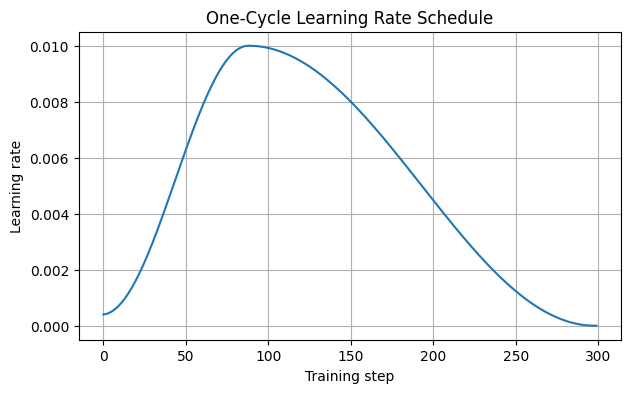

In [ ]:
import torch, torch.nn as nn, matplotlib.pyplot as plt

model = nn.Linear(10, 1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=100,
    epochs=3,
    pct_start=0.3,
    anneal_strategy='cos'
)

lrs = []
for _ in range(3 * 100):
    scheduler.step()
    lrs.append(scheduler.get_last_lr()[0])

plt.figure(figsize=(7,4))
plt.plot(lrs)
plt.title("One-Cycle Learning Rate Schedule")
plt.xlabel("Training step")
plt.ylabel("Learning rate")
plt.grid(True)
plt.show()


### **9.5 How the Optimizer Interacts with the Loss**


In [ ]:
# criterion = WeightedMSELoss()
# loss = criterion(y_pred, y_true, y_std)
# optimizer.zero_grad()                      # clear old gradients
# loss.backward()                            # compute new gradients
# torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # avoid explosion
# optimizer.step()                           # update weights
# scheduler.step()                           # adjust learning rate

## 10 Why Sampling and How It Works (seq2one, regression)

### 10.1 Why we need sampling

Imagine we have many years of daily data for each basin — precipitation, temperature, PET, etc.
We can’t feed the whole time series (thousands of days) into the model at once.
Instead, we **cut the long sequence into smaller overlapping pieces**.

Each piece is called a **window** — for example, 365 days of continuous inputs.
For every window, we train the model to predict **only one value**: the **runoff on the last day** in that window.

This is called **seq2one sampling**: “sequence in → one value out”.

It’s still regression — we’re not forecasting the future, just learning the relationship between **past forcing** and **current runoff**.

---

### 10.2 The idea in one basin

Think of a single basin as a long line of daily data, like this:

```
| day1 | day2 | ... | day364 | day365 | day366 | ... | dayT |
```

Now take a box of width **L = 365**.
Place it at the start — the box covers the first 365 days.
The **target** is the runoff on day 365 (the last day in the box).

Then slide the box one day to the right:

* The box now covers days 2–366,
* The target is the runoff on day 366.

Keep sliding until the end.
This creates many training samples: each one is “365 days of input → 1 runoff”.

To make it clearer, here’s a small 10-day toy example with a shorter window (L = 4):

| Sample | Input Days | Target Day |
| :----: | :--------: | :--------: |
|    1   |     1–4    |      4     |
|    2   |     2–5    |      5     |
|    3   |     3–6    |      6     |
|    4   |     4–7    |      7     |
|    5   |     5–8    |      8     |
|    6   |     6–9    |      9     |

---

### 10.3 Warm-up

At the very beginning (day 1), we don’t yet have 365 previous days to form a full box.
So the first 364 days are used as a **warm-up** — they’re not wasted; they’re needed to fill the first complete window.

After that, every day can be the “last day” of one full window.

---

### 10.4 From one basin to many basins

If you have several basins, imagine stacking those long rows on top of each other:

```
Basin 1: |----------------------|
Basin 2: |----------------------|
Basin 3: |----------------------|
```

Each basin has its own series of sliding windows.
All windows across all basins can be listed together.

We can label them with a simple counting index:

* Start counting from 0 at the top-left (first basin, first window),
* Keep counting row by row.

Later, if you pick one random index, you can find:

* Which basin it belongs to (by integer division),
* The window’s start position (by modulo).

So **making mini-batches** simply means:

> cut every basin’s time series into many windows,
> put all windows into one big list,
> and randomly grab a few of them each training step.

This gives the model diverse samples and keeps memory usage small.



### 10.5 Visualizing the concept

https://dl4water.github.io/tutorial-sampling-viz

![Example](https://raw.githubusercontent.com/dl4water/dl4water-workshop-2025/main/2025-10-18_Building_LSTM_and_Transformer_Models_for_Hydrologic_Prediction/figures/sampling_example.JPG)

## 11 Dataset and DataLoader (The Bridge to Training Loop)

### **11.1 What is a Dataset**

In PyTorch, a **Dataset** is just a small class that tells the framework two things:

1. **How many samples you have** — implemented by `__len__`
2. **How to get one sample by its index** — implemented by `__getitem__`

When you write your own Dataset, you decide **how to fetch a single (x, y) pair** from your data.
That’s where your sampling logic from the previous section comes in.

---

### **11.2 Minimal Dataset Example**

Let’s look at the simplest possible custom Dataset.


In [ ]:
import torch
from torch.utils.data import Dataset

class SimpleDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data      # for example: [N, seq_len, features]
        self.labels = labels  # for example: [N, 1]

    def __len__(self):
        # tells how many total samples exist
        return len(self.data)

    def __getitem__(self, idx):
        # given an index, return one sample
        x = self.data[idx]
        y = self.labels[idx]
        return x, y


* `__len__`: allows Python to call `len(dataset)`
* `__getitem__`: lets you access samples like `dataset[5]`

---

### **11.3 What is a DataLoader**

A **DataLoader** is a PyTorch utility that automatically:

* Reads samples from your Dataset in small **batches**
* **Shuffles** the order each epoch
* Moves them efficiently to the model (with multiple workers if needed)

You can think of it as a **batch generator** for training.

---

### **11.4 Example Usage**


In [ ]:
from torch.utils.data import DataLoader

# pretend we already built arrays of 1000 samples
data = torch.randn(1000, 365, 5)   # 1000 windows, 365 days, 5 features
labels = torch.randn(1000, 1)      # runoff at last day

dataset = SimpleDataset(data, labels)

# build DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# check a single batch
for batch_x, batch_y in loader:
    print("Batch X:", batch_x.shape)  # [32, 365, 5]
    print("Batch Y:", batch_y.shape)  # [32, 1]
    break

Batch X: torch.Size([32, 365, 5])
Batch Y: torch.Size([32, 1])


When you iterate over `loader`, it:

1. Randomly picks 32 indices
2. Calls `__getitem__` for each index
3. Combines them into one batch
4. Returns that batch to your training loop

---

### **11.5 How it connects to training**

Once the DataLoader is ready, your **training loop** just says:

In [ ]:
# for x, y in train_loader:
#     y_pred = model(x)
#     loss = criterion(y_pred, y)

## 12. A complete training example

In [ ]:
import os
import sys
import random
import pandas as pd
import numpy as np
from types import SimpleNamespace
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset as DS
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
sys.path.append("/content/data")
from nc_reader import Preprocessor

# configuration
seq_len = 365 # using 1 year data for training
pred_len = 1 # predicting 1 day runoff
epochs = 30
batch_size = 256
hidden_size = 256 # LSTM hidden size
dropout = 0.4
learning_rate = 0.001 # initial learning rate
seed = 0

# fix seed for reproducibility
np.random.seed(seed)
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

config_data_dict = {
    'input_nc_file':  '/content/data/CAMELS_subset.nc',
    'train_date_list': ["1980-10-01", "1995-09-30"],
    'val_date_list': None,
    'test_date_list': ["1995-10-01", "2010-09-30"],
    'time_series_variables': ['daymet_prcp', 'daymet_srad', 'daymet_tmax', 'daymet_tmin', 'daymet_dayl', 'daymet_vp'],
    'target_variables': ['Runoff'],
    'static_variables': ['elev_mean', 'slope_mean', 'area_gages2', 'frac_forest', 'lai_max', 'lai_diff', 'gvf_max',
                         'gvf_diff', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
                         'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac',
                         'geol_permeability', 'p_mean', 'pet_mean', 'aridity', 'frac_snow', 'high_prec_freq',
                         'high_prec_dur', 'low_prec_freq', 'low_prec_dur'],
    'station_ids': None,
}
config_dataset = SimpleNamespace(**config_data_dict) # dataset configuration


class Dataset(DS):
    def __init__(self, seq_len, pred_len, prep, flag='train', scaler=None):
        self.seq_len, self.pred_len, self.prep = seq_len, pred_len, prep
        warmup_days = self.seq_len - self.pred_len # to obtain the full prediction length
        self.data_dict_all = prep.load_and_process(split=flag, warmup_days=warmup_days, scaler=scaler)
        self.norm_x = self.data_dict_all["norm_x"] # [bs, time, features]
        self.scaler = self.data_dict_all["scaler"] # record the mean and std for each variable
        self.num_windows = self.norm_x.shape[1] - self.seq_len + 1 # sliding windows
        self.num_basin = self.norm_x.shape[0] # number of basins
        self.index_matrix = np.arange(self.num_basin * self.num_windows)

    def __len__(self):
        return self.num_basin * self.num_windows

    def __getitem__(self, idx):
        idx_basin = idx // self.num_windows # which basin
        idx_time = idx % self.num_windows # which time window for the basin

        sub_x = self.data_dict_all["norm_x"][idx_basin, idx_time:idx_time + self.seq_len, :]  # (seq_len, features)
        sub_y = self.data_dict_all["norm_y"][idx_basin, idx_time:idx_time + self.seq_len, :]
        sub_c = self.data_dict_all["norm_c"][idx_basin]  # features
        target_std_list = self.scaler["y_std_samples"][idx_basin].astype(np.float32).copy()

        data_dict = {"batch_x": torch.from_numpy(sub_x.astype(np.float32)),
                     "batch_y": torch.from_numpy(sub_y.astype(np.float32)),
                     "batch_c": torch.from_numpy(sub_c.astype(np.float32)),
                     "batch_target_std": torch.from_numpy(target_std_list), }
        return data_dict


def nse(obs, sim):
    idx = (obs >= 0) & (~np.isnan(obs)) & (~np.isnan(sim))
    obs, sim = obs[idx], sim[idx]
    denominator = ((obs - obs.mean()) ** 2).sum()
    numerator = ((sim - obs) ** 2).sum()
    value = 1 - numerator / denominator
    return value


class MSELoss(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, y_hat, y, y_std=None):
        mask = ~torch.isnan(y) # mask the missing values
        squared_error = (y_hat[mask] - y[mask]) ** 2
        if y_std is not None and 0 not in y_std.size():
            target_stds = y_std.unsqueeze(1).expand_as(y_hat)
            weights = 1 / (target_stds[mask] + 0.1) ** 2
        else:
            weights = 1.0
        return torch.mean(weights * squared_error)


class LSTM(nn.Module):

    def __init__(self, c_in, c_out, hidden_size, dropout):
        super().__init__()

        self.lstm = nn.LSTM(input_size=c_in, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=dropout)
        self.project = nn.Linear(hidden_size, c_out)
        self.lstm.bias_hh_l0.data[hidden_size:2 * hidden_size] = 3

    def forward(self, data_dict):
        x, c = data_dict['batch_x'], data_dict['batch_c']
        x = torch.cat([x, c.unsqueeze(1).repeat(1, x.shape[1], 1)], dim=-1)

        lstm_output, (h_n, c_n) = self.lstm(input=x)
        y_pred = self.project(self.dropout(lstm_output))

        return {"outputs_time_series": y_pred, }


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
prep = Preprocessor(config_dataset)
train_dataset = Dataset(seq_len=seq_len, pred_len=pred_len, prep=prep, flag='train', scaler=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
scaler = train_dataset.scaler
test_dataset = Dataset(seq_len=seq_len, pred_len=pred_len, prep=prep, flag='test', scaler=scaler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = LSTM(c_in=len(config_dataset.time_series_variables) + len(config_dataset.static_variables),
             c_out=1, hidden_size=hidden_size, dropout=dropout)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    max_lr=3e-3,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,  # 30% of the cycle is used for increasing the learning rate
    anneal_strategy='cos',
    div_factor=10,  # LR = max_lr / 10
    final_div_factor=1e4  # LR = max_lr / 1e4
)

loss_func = MSELoss()
model = model.to(device)

# training
for epoch in range(1, epochs + 1):
    print("epoch: ", epoch)
    model.train()
    for i, batch_data_dict in enumerate(train_loader):
        optimizer.zero_grad()
        batch_data_dict = {key: value.float().to(device) for key, value in batch_data_dict.items()}
        output_dict = model(batch_data_dict)

        batch_y = batch_data_dict["batch_y"][:, -pred_len:, :]
        outputs_time_series = output_dict["outputs_time_series"][:, -pred_len:, :]
        target_stds = batch_data_dict["batch_target_std"]
        loss = loss_func(outputs_time_series, batch_y, target_stds)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

# testing
preds, trues = [], []
model.eval()
with torch.no_grad():
    for i, batch_data_dict in enumerate(test_loader):
        batch_data_dict = {key: value.float().to(device) for key, value in batch_data_dict.items()}
        output_dict = model(batch_data_dict)

        true = batch_data_dict["batch_y"][:, -pred_len:, :]
        pred = output_dict["outputs_time_series"][:, -pred_len:, :]

        preds.append(pred.detach().cpu().numpy())
        trues.append(true.detach().cpu().numpy())

preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)

# restore the shape
preds_restored = test_dataset.prep.restore_data(data=preds, num_stations=test_dataset.num_basin)
trues_restored = test_dataset.prep.restore_data(data=trues, num_stations=test_dataset.num_basin)
# de-normalization
preds_rescale = test_dataset.prep.inverse_transform(preds_restored, mean=test_dataset.scaler["y_mean"],
                                                 std=test_dataset.scaler["y_std"])[:, :, 0]
trues_rescale = test_dataset.prep.inverse_transform(trues_restored, mean=test_dataset.scaler["y_mean"],
                                                 std=test_dataset.scaler["y_std"])[:, :, 0]

# calculate the metrics
NSE_values = []
for idx_basin in range(trues_rescale.shape[0]):
    NSE_values.append(nse(trues_rescale[idx_basin], preds_rescale[idx_basin]))
print("median_NSE: ", np.nanmedian(NSE_values))


epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
median_NSE:  0.6977954359143138


https://zenodo.org/records/17216705

## 13 **Using Your Own Data**

### **13.1 The Goal**

Everything we did with CAMELS — downloading, preprocessing, normalizing, sampling, training — can be reused **if your own data have the same structure**.

You don’t need to rewrite the code.
You just need to prepare your data in the **same format** as the CAMELS subset we used.

---

### **13.2 Required data format**

Your dataset should contain **three parts**:

| Name          | Shape                   | Description                                                  |
| ------------- | ----------------------- | ------------------------------------------------------------ |
| `forcing`     | (basin, time, feature)  | Daily meteorological inputs (precip, temperature, PET, etc.) |
| `target`      | (basin, time, 1)        | Runoff or discharge (the variable you want to model)         |
| `static_data` | (basin, static_feature) | Catchment attributes that do not change over time            |

---

### **13.3 How to save it as a NetCDF file**

You can use **xarray** to create a dataset that matches CAMELS format.

Here’s an example:


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# Define dimensions
n_basins = 5
n_time = 1000
n_features = 6
n_static = 4

# Generate sample data arrays
time_series_data = np.random.rand(n_basins, n_time, n_features)
static = np.random.rand(n_basins, n_static)

# Define coordinate information
basin_ids = [f"B{i:03d}" for i in range(n_basins)]
time = pd.date_range("2000-01-01", periods=n_time, freq="D")
time_series_names = ["prcp", "tmean", "tmax", "tmin", "srad", "runoff"]
static_names = ["elev_mean", "area", "slope", "forest_frac"]

# Create data variables dictionary
data_vars = {}

# Expand time series data into individual variables
# Each variable has dimensions (basin, time)
for i, var_name in enumerate(time_series_names):
    data_vars[var_name] = (["basin", "time"], time_series_data[:, :, i])

# Add static variables
# Each variable has dimension (basin) only
for i, var_name in enumerate(static_names):
    data_vars[var_name] = (["basin"], static[:, i])

# Build the xarray Dataset
ds = xr.Dataset(
    data_vars=data_vars,
    coords={
        'basin': basin_ids,
        'time': time,
    },
    attrs={
        'title': 'Hydrological Basin Dataset',
        'creation_date': pd.Timestamp.now().isoformat(),
    }
)

# Save to NetCDF file
ds.to_netcdf("my_dataset.nc")
print("✅ Saved to my_dataset.nc")
ds

✅ Saved to my_dataset.nc


<xarray.Dataset> Size: 248kB
Dimensions:      (basin: 5, time: 1000)
Coordinates:
  * basin        (basin) <U4 80B 'B000' 'B001' 'B002' 'B003' 'B004'
  * time         (time) datetime64[ns] 8kB 2000-01-01 2000-01-02 ... 2002-09-26
Data variables:
    prcp         (basin, time) float64 40kB 0.5154 0.8843 ... 0.1901 0.221
    tmean        (basin, time) float64 40kB 0.3695 0.443 ... 0.1482 0.123
    tmax         (basin, time) float64 40kB 0.3025 0.6234 ... 0.6842 0.5432
    tmin         (basin, time) float64 40kB 0.9049 0.4827 ... 0.1161 0.3306
    srad         (basin, time) float64 40kB 0.898 0.7202 ... 0.8768 0.1552
    runoff       (basin, time) float64 40kB 0.6628 0.0952 ... 0.3241 0.3948
    elev_mean    (basin) float64 40B 0.06266 0.4757 0.2429 0.6262 0.9239
    area         (basin) float64 40B 0.3558 0.7461 0.259 0.486 0.5684
    slope        (basin) float64 40B 0.185 0.8731 0.4756 0.9484 0.4648
    forest_frac  (basin) float64 40B 0.002031 0.2502 0.7766 0.04661 0.3269
Attributes:
    title:          Hydrological Basin Dataset
    creation_date:  2025-10-17T22:32:48.568089

## 14. Transformer model

The LSTM learns temporal dependencies step by step — day by day — which can make it slow or hard to capture long-term patterns.
The **Transformer**, instead, looks at the *entire sequence at once*.
It uses a mechanism called **self-attention** to decide *which days in the past matter most* for predicting the current runoff.

In other words:

> “Instead of remembering one day at a time, the Transformer can directly connect rainfall 100 days ago to today’s runoff.”

---

### **14.1 The basic building blocks**

A Transformer is made of three key parts:

1. **Positional Encoding** – adds information about the order of days in the sequence.
   (Because attention itself doesn’t know which input is earlier or later.)

2. **Self-Attention Layer** – compares each day with all other days in the window to compute how important they are to each other.

3. **Feed-Forward Layer** – a small neural network that processes each day’s attended features.

A Transformer model is usually a **stack** of several of these layers, each helping the model learn more complex temporal patterns.

---

### **14.2 Visual intuition**

![Example](https://raw.githubusercontent.com/dl4water/dl4water-workshop-2025/main/2025-10-18_Building_LSTM_and_Transformer_Models_for_Hydrologic_Prediction/figures/Transformer.jpg)

(credit: https://doi.org/10.1016/j.jhydrol.2024.131389)

You can think of self-attention as giving “attention weights” to each day —
the model learns which previous events most influence the output.

---

### **14.3 The simplest working Transformer example**

Here’s a **minimal PyTorch demo** that shows how the built-in `nn.TransformerEncoder` works.
We’ll feed random sequences through it just to see the shapes.


In [ ]:
import torch
import torch.nn as nn
import math

class SimpleTransformer(nn.Module):
    """
    Simplest Transformer for time series regression prediction
    """
    def __init__(self, input_dim, d_model=64, n_heads=4, n_layers=2, dropout=0.1):
        """
        Args:
            input_dim: Input feature dimension (e.g., number of features like rainfall, temperature)
            d_model: Transformer internal feature dimension
            n_heads: Number of attention heads
            n_layers: Number of encoder layers
            dropout: Dropout rate
        """
        super().__init__()

        # Input projection: map input features to d_model dimension
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True  # Input format: [batch, seq_len, features]
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Output layer: regression prediction
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        Args:
            x: [batch_size, seq_len, input_dim]
        Returns:
            output: [batch_size, seq_len, 1] - Runoff prediction for each time step
        """
        # Input projection
        x = self.input_projection(x)  # [batch, seq_len, d_model]

        # Add positional encoding
        x = self.pos_encoding(x)

        # Transformer encoding
        x = self.transformer_encoder(x)  # [batch, seq_len, d_model]

        # Output prediction
        output = self.output_layer(x)  # [batch, seq_len, 1]

        return output


class PositionalEncoding(nn.Module):
    """Positional Encoding"""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: [batch_size, seq_len, d_model]
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# Parameter settings
batch_size = 32
seq_len = 168  # e.g., hourly data for the past 7 days
input_dim = 5  # e.g., rainfall, temperature, humidity, wind speed, evaporation

# Create model
model = SimpleTransformer(
    input_dim=input_dim,
    d_model=64,
    n_heads=4,
    n_layers=2,
    dropout=0.1
)

# Create dummy data
x = torch.randn(batch_size, seq_len, input_dim)

# Forward pass
output = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")  # [32, 168, 1]


Input shape: torch.Size([32, 168, 5])
Output shape: torch.Size([32, 168, 1])
